In [1]:

%matplotlib inline
import numpy as np
from pathlib import Path

import menpo.io as mio
from menpo.feature import fast_dsift, ndfeature
from menpo.landmark import face_ibug_68_to_face_ibug_68_trimesh, labeller

from menpodetect import load_dlib_frontal_face_detector

from menpofit.aam import HolisticAAM, LucasKanadeAAMFitter

from menpowidgets import visualize_fitting_result


In [2]:
# Here I make a little feature wrapper which just converts
# the 64-bit dense sift features into 32-bit. This
# doesn't effect performance in practise and saves
# us half the memory!
@ndfeature
def float32_fast_dsift(x):
    return fast_dsift(x).astype(np.float32)

In [3]:
# Load the DLIB detector which is fairly strong
# and has a very low number of false positives
detector = load_dlib_frontal_face_detector()

In [4]:
# Loading our testing image
image_path = Path('/home/manik/images/messi3.jpg')
image = mio.import_image(image_path)
print(detector(image))

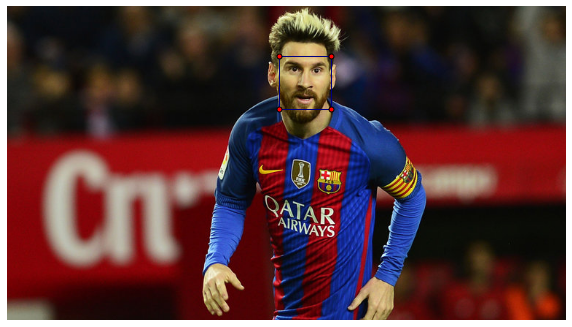

In [5]:
image.view_widget()

In [6]:
# Just a short helper method to crop the images
# and turn to greyscale - again to save memory
def load_image(i):
    i = i.crop_to_landmarks_proportion(0.5)
    if i.n_channels == 3:
        i = i.as_greyscale()
    # This step is actually quite important! If we are using
    # an AAM and a PiecewiseAffine transform then we need
    # to ensure that our triangulation is sensible so that
    # we don't end up with ugly skinny triangles. Luckily,
    # we provide a decent triangulation in the landmarks
    # package.
    labeller(i, 'PTS', face_ibug_68_to_face_ibug_68_trimesh)
    return i

In [7]:
training_images_path = Path('/home/manik/lfpw/trainset')
training_images = [load_image(i) for i in mio.import_images(training_images_path, verbose=True)]

Found 811 assets, index the returned LazyList to import.


In [8]:
# Build the AAM. There are a number of important things to note here:
#  - Use the landmark group pertaining to the sensible triangulation
#  - Use the float32 fast dense sift features (saves memory)
#  - 2 scales works well in practise
#  - Rescaling the diagonal saves a lot of memory. In general
#    somewhere between 150 and 250 is sufficient. More and you
#    waste memory without any improvement, less and the face
#    can become too small. Keep in mind that the features are
#    actually quite tightly coupled with the size of the image.
#    The default parameters for fast_dsift were designed assuming
#    a diagonal of between 150 and 200.
#  - max_appearance_components and max_shape_components are simply
#    used to save more memory, as we just throw away the extra
#    PCA components
aam = HolisticAAM(
    training_images,
    group='face_ibug_68_trimesh',
    holistic_features=float32_fast_dsift,
    scales=(0.5, 1.0),
    diagonal=150,
    max_appearance_components=200,
    max_shape_components=20,
    verbose=True
)

# Ignore the warnings about the triangulation. This can happen
# on some images where the pose causes very skinny triangles.
# In this case the warped image just ends up receiving 0
# values.

- Computing reference shape                                                     Computing batch 0
- Building models
  - Scale 0: Done
  - Scale 1: Done
                                                              

In [9]:
# This is absolutely critical to decent AAM performance.
# We used two scales because we wanted to try and ensure
# that the first iterations of the AAM try and correct
# for the gross deformations that map to similarity misalignments.
# If you don't clip the number of shape components down, your
# fitting will NOT work! Intuitively, this is because the AAM
# is optimising over an energy function that is parametrised by 
# the shape components. The larger the dimensionality of the space,
# the higher the probability the space will contain many local optima.
# Similarly, the number of appearance components also cuts out a lot
# of the noise and improves fitting performance time.
aam_fitter = LucasKanadeAAMFitter(
    aam,
    n_shape=[5, 15],
    n_appearance=[50, 150]
)

In [10]:
# The number of iterations can also play a huge role.
# You may want to take a look at the iterations tab
# in the widget below. There you might see that 
# the function converges and spends a lot of time
# doing nothing (often at the first scale). In this
# case you probably want to reduce the number of iterations
# to something like [15, 25] or similar. Play around!
result = aam_fitter.fit_from_bb(image, 
                                image.landmarks['dlib_0'].lms, 
                                max_iters=30)

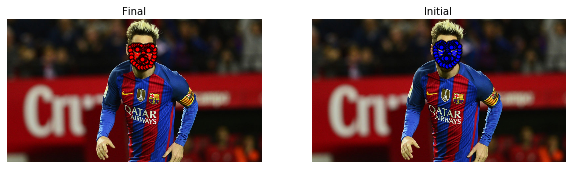

In [11]:
visualize_fitting_result(result)

In [12]:
# Loading our testing image
image2_path = Path('/home/manik/images/ronaldo2.jpg')
image2 = mio.import_image(image2_path)
print(detector(image2))

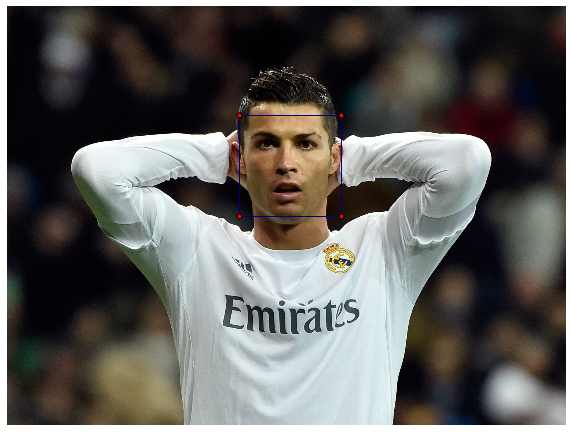

In [13]:
image2.view_widget()

In [14]:
result = aam_fitter.fit_from_bb(image2, 
                                image2.landmarks['dlib_0'].lms, 
                                max_iters=30)

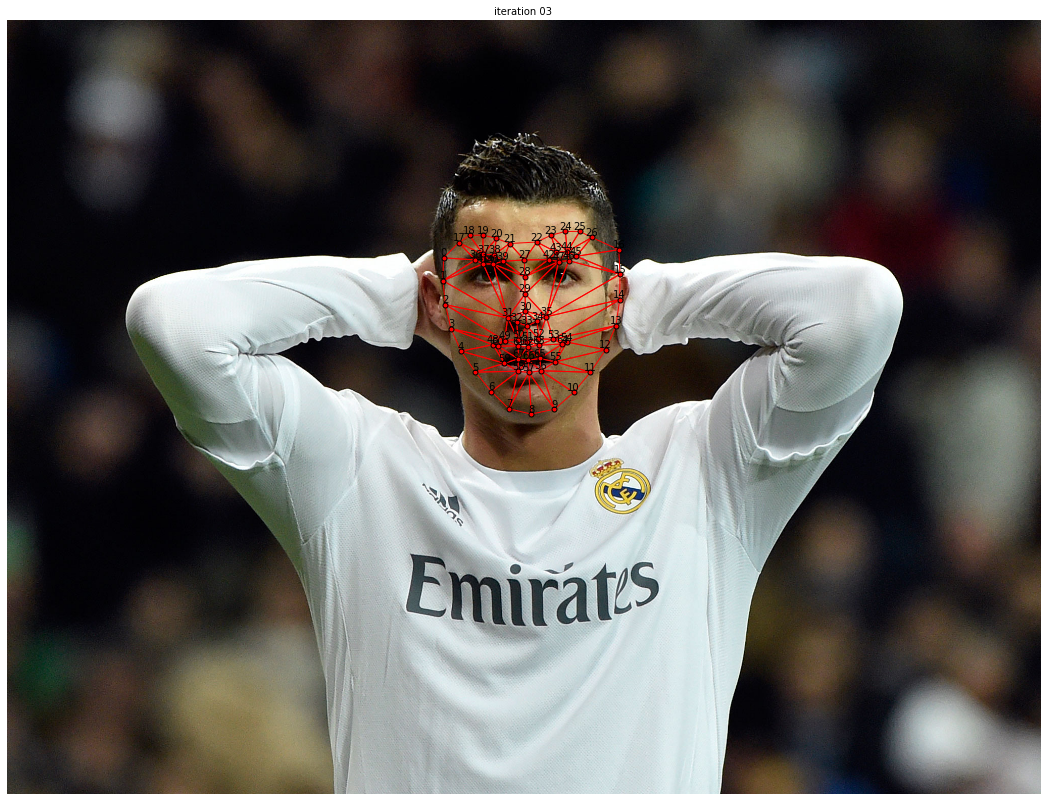

In [15]:
visualize_fitting_result(result)

In [36]:
print result.final_shape.points

[[  531.97325305   867.45663588]
 [  572.89232972   869.72306628]
 [  612.93188322   876.68574954]
 [  651.56425216   889.20088757]
 [  687.19903808   906.51120253]
 [  719.51878373   929.26010384]
 [  747.88918406   956.72097302]
 [  771.24408587   989.16590563]
 [  779.23724496  1028.00626192]
 [  771.83075867  1066.47593611]
 [  747.02580208  1100.40110364]
 [  717.90916536  1130.30621742]
 [  684.6525831   1154.66117077]
 [  647.47851374  1172.0466211 ]
 [  607.67882733  1182.68641102]
 [  567.07909147  1188.32931941]
 [  526.23519098  1189.25894431]
 [  478.07901791   894.88956584]
 [  464.16771627   916.60799895]
 [  461.40350159   942.43847626]
 [  466.72862542   969.25987271]
 [  477.96939251   993.84524682]
 [  479.60155809  1052.31200347]
 [  468.58229752  1079.71834306]
 [  464.00002344  1107.2269803 ]
 [  467.51760133  1134.2429883 ]
 [  480.97203396  1155.83394169]
 [  511.63654506  1023.83211236]
 [  535.84056447  1022.94479393]
 [  560.30147474  1022.1781441 ]
 [  585.55